<a href="https://colab.research.google.com/github/olgapoletkina/sf_data_science/blob/main/Home_Work_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача
Для закрепления пройденного материала предлагаем вам следующее задание: используя библиотеку kaggle-environments, реализующую функционал взаимодействия между виртуальными агентами в рамках нескольких популярных игр, реализовать самостоятельно несколько агентов и сравнить их в игре «камень-ножницы-бумага».

### Вам необходимо:
Описать поведение бота, который будет играть с такими же ботами в игру «камень-ножницы-бумага». Поведение бота описывается с помощью функции, которая принимает на вход информацию о прошлых играх. (сигнатура функции приведена в Google Colab, а детальное описание входящих значений доступно по ссылке)
После описания поведения агентов запустить турнир между ними и проверить, какая стратегия показывает себя лучше всех.
Отметим, что вам необязательно использовать «качественные» стратегии — в этом задании основной упор необходимо сделать на разнообразие (т.е. агенты, которые бы играли, придерживаясь стратегии «только камень» или »только ножницы» – это нормально).

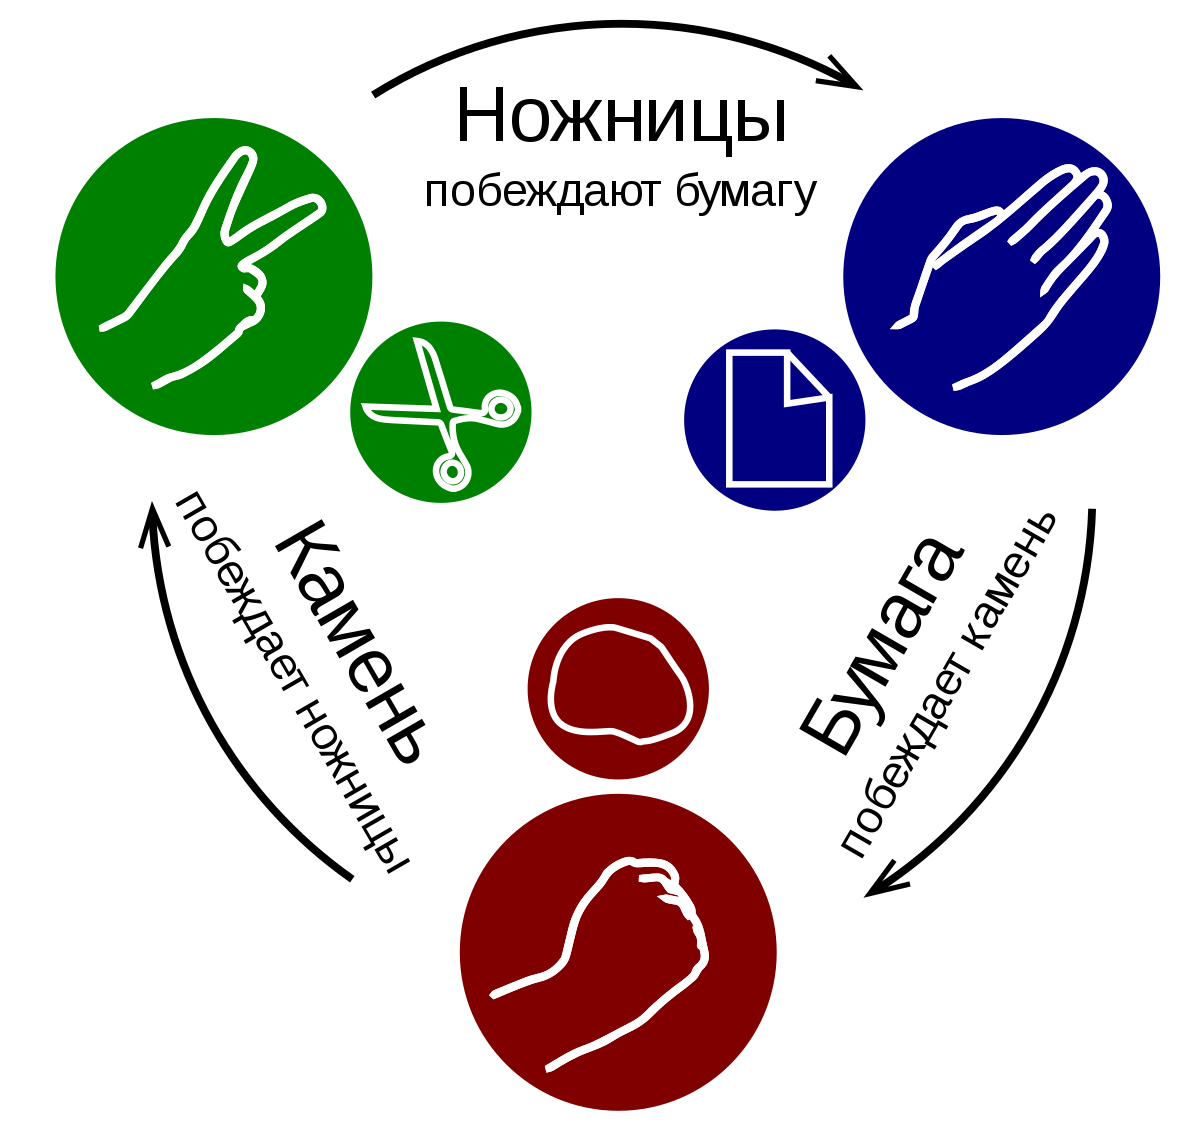

## Установка и импорт библиотек

In [182]:
!pip install -q kaggle_environments

In [183]:
import random
from kaggle_environments import make, evaluate
import pandas as pd
import plotly.express as px

## Определение базовых стратегий

### Простые агенты:
- 1 - rock_agent
- 2 - scissors_agent
- 3 - paper_agent

Создадим **несколько простых агентов** для "Камень-ножницы-бумага". Каждый агент имеет свою стратегию: один будет всегда выбирать **"Камень"**, другой — **"Ножницы"**, третий — **"Бумагу"**.

In [184]:
def rock_agent(observation, configuration):
    return 0

def paper_agent(observation, configuration):
    return 1

def scissors_agent(observation, configuration):
    return 2

### Агент, копирующий действия противника
- 4 - copy_opponent_agent

In [185]:
def copy_opponent_agent(observation, configuration):
    if observation.step > 0 and observation.lastOpponentAction is not None:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

### Реактивный агент

- 5 - reactionary_agent

**Меняет действия на основе результата предыдущего хода**, пытаясь победить последний выбор противника.

In [186]:
def make_reactionary_agent():
    last_action = None
    def reactionary_agent(observation, configuration):
        nonlocal last_action
        if observation.step == 0:
            last_action = random.randrange(0, configuration.signs)
        else:
            last_action = (observation.lastOpponentAction + 1) % configuration.signs
        return last_action
    return reactionary_agent

### Статистический агент
- 6 - sattistical_agent

**Анализирует частоту действий противника** и выбирает действие, которое с наибольшей вероятностью его победит.

In [187]:
def make_statistical_agent():
    action_histogram = {}
    def statistical_agent(observation, configuration):
        nonlocal action_histogram
        if observation.step == 0:
            action_histogram = {}
            return random.randrange(0, configuration.signs)
        else:
            action = observation.lastOpponentAction
            action_histogram[action] = action_histogram.get(action, 0) + 1
            mode_action = max(action_histogram, key=action_histogram.get)
            return (mode_action + 1) % configuration.signs
    return statistical_agent

### Случайный агент

- 7 - random_agent

In [188]:
def random_agent(observation, configuration):
    return random.randrange(0, configuration.signs)

### Цикличный агент
- 8 - cycle_agent

Последовательно проходит через все действия: **"Камень", "Бумага", "Ножницы" и снова повторяет**

In [189]:
def make_cycle_agent():
    cycle_action = 0
    def cycle_agent(observation, configuration):
        nonlocal cycle_action
        action = cycle_action
        cycle_action = (cycle_action + 1) % configuration.signs
        return action
    return cycle_agent

### Анти-копирующий агент
- 9 - anti_copy_agent

**Меняет свой выбор на случайный**, если замечает, что противник копирует его прошлый ход.

In [190]:
def make_anti_copy_agent():
    last_action = None
    def anti_copy_agent(observation, configuration):
        nonlocal last_action
        if observation.step > 0 and last_action is not None and observation.lastOpponentAction == last_action:
            action = random.randrange(0, configuration.signs)
        else:
            action = 0
        last_action = action
        return action
    return anti_copy_agent

### Агент, обнаруживающий шаблоны
- 10 - pattern_detector_agent

**Ищет повторяющиеся шаблоны в последних ходах противника** и выбирает действие, побеждающее шаблон.

In [191]:
def make_pattern_detector_agent():
    pattern_history = []
    def pattern_detector_agent(observation, configuration):
        nonlocal pattern_history
        if observation.step == 0:
            pattern_history = []
            return random.randrange(0, configuration.signs)
        else:
            pattern_history.append(observation.lastOpponentAction)
            if len(pattern_history) >= 3 and pattern_history[-3:] == [pattern_history[-1]]*3:
                return (pattern_history[-1] + 1) % configuration.signs
            return random.randrange(0, configuration.signs)
    return pattern_detector_agent

### Адаптивный агент
- 11 - adaptive_agent

**Отслеживает частоту действий противника** и выбирает ход, побеждающий наиболее часто используемое действие

In [192]:
def make_adaptive_agent():
    opponent_actions_frequency = {0: 0, 1: 0, 2: 0}
    def adaptive_agent(observation, configuration):
        nonlocal opponent_actions_frequency
        if observation.step > 0:
            opponent_actions_frequency[observation.lastOpponentAction] += 1
        most_common_action = max(opponent_actions_frequency, key=opponent_actions_frequency.get)
        return (most_common_action + 1) % configuration.signs
    return adaptive_agent

### Умный случайный агент
- 12 - smart_random_agent

**Выбирает случайное действие с повышенной вероятностью повторить ход**, который был успешным в предыдущих играх.

In [193]:
def make_smart_random_agent():
    smart_action_weights = [1, 1, 1]
    last_action = None
    def smart_random_agent(observation, configuration):
        nonlocal smart_action_weights, last_action
        if observation.step > 0 and last_action is not None:
            result = (last_action - observation.lastOpponentAction) % configuration.signs
            if result == 1:
                smart_action_weights[last_action] += 1
            elif result == 2:
                smart_action_weights[last_action] = max(1, smart_action_weights[last_action] - 1)
        action = random.choices(range(configuration.signs), weights=smart_action_weights)[0]
        last_action = action
        return action
    return smart_random_agent

### Агент обратной частоты
- 13 - inverse_frequency_agent

**Отслеживает частоту ходов противника и выбирает действие**, которое побеждает наименее часто используемый им ход, пытаясь воспользоваться его пренебрегаемыми действиями

In [194]:
def make_inverse_frequency_agent():
    opponent_action_counts = [0]*3

    def inverse_frequency_agent(observation, configuration):
        nonlocal opponent_action_counts
        if observation.step > 0:
            opponent_action_counts[observation.lastOpponentAction] += 1
        # находим наименее частый ход противника
        min_count = min(opponent_action_counts)
        least_played_actions = [i for i, count in enumerate(opponent_action_counts) if count == min_count]
        # выбираем случайный из наименее частых ходов
        least_played_action = random.choice(least_played_actions)
        # выбираем действие, побеждающее наименее частый ход
        action = (least_played_action + 1) % configuration.signs
        return action

    return inverse_frequency_agent

### Анти-реактивный агент

- 14 - anti_reactionary_agent

**Предполагает, что противник является реактивным и пытается опередить его**, выбирая действие, которое побеждает предполагаемый ответ противника на наш предыдущий ход.

In [195]:
def make_anti_reactionary_agent():
    last_action = None

    def anti_reactionary_agent(observation, configuration):
        nonlocal last_action
        if observation.step == 0:
            action = random.randrange(0, configuration.signs)
        else:
            # предполагаем, что противник выберет действие, побеждающее наш предыдущий ход
            predicted_opponent_move = (last_action + 1) % configuration.signs
            # выбираем действие, побеждающее предполагаемый ход противника
            action = (predicted_opponent_move + 1) % configuration.signs
        last_action = action
        return action

    return anti_reactionary_agent

## Запуск турнира между агентами

In [196]:
agents = {
    "rock": lambda: rock_agent,
    "paper": lambda: paper_agent,
    "scissors": lambda: scissors_agent,
    "copy_opponent": lambda: copy_opponent_agent,
    "reactionary": make_reactionary_agent,
    "statistical": make_statistical_agent,
    "random": lambda: random_agent,
    "cycle": make_cycle_agent,
    "anti_copy": make_anti_copy_agent,
    "pattern_detector": make_pattern_detector_agent,
    "adaptive": make_adaptive_agent,
    "smart_random": make_smart_random_agent,
    "inverse_frequency": make_inverse_frequency_agent,
    "anti_reactionary": make_anti_reactionary_agent
}

### Подсчет очков
- 1 - победа
- 0 - ничья
- -1 - поражение

In [197]:
results = {}
for agent1_name, agent1_creator in agents.items():
    for agent2_name, agent2_creator in agents.items():
        if agent1_name != agent2_name:
            agent1 = agent1_creator()
            agent2 = agent2_creator()
            outcomes = evaluate(
                "rps",
                [agent1, agent2],
                configuration={"episodeSteps": 100, "tieReward": 0, "winReward": 1, "lossReward": -1},
                num_episodes=1
            )
            score = outcomes[0][0]
            results[(agent1_name, agent2_name)] = score

for (agent1, agent2), score in results.items():
    print(f"Результат игры между {agent1} и {agent2}: {score}")

Результат игры между rock и paper: -99.0
Результат игры между rock и scissors: 99.0
Результат игры между rock и copy_opponent: 0
Результат игры между rock и reactionary: -97.0
Результат игры между rock и statistical: -99.0
Результат игры между rock и random: 0
Результат игры между rock и cycle: 0
Результат игры между rock и anti_copy: 0
Результат игры между rock и pattern_detector: -96.0
Результат игры между rock и adaptive: -99.0
Результат игры между rock и smart_random: -69.0
Результат игры между rock и inverse_frequency: 54.0
Результат игры между rock и anti_reactionary: 0
Результат игры между paper и rock: 99.0
Результат игры между paper и scissors: -99.0
Результат игры между paper и copy_opponent: 0
Результат игры между paper и reactionary: -99.0
Результат игры между paper и statistical: -97.0
Результат игры между paper и random: 0
Результат игры между paper и cycle: 0
Результат игры между paper и anti_copy: 99.0
Результат игры между paper и pattern_detector: -97.0
Результат игры 

### Создание  DataFrame с уникальными результатами матчей

In [198]:
pd.set_option('display.max_rows', None)

In [199]:
df_results = pd.DataFrame(results.items(), columns=['Game', 'Score'])
df_results[['Agent 1', 'Agent 2']] = pd.DataFrame(df_results['Game'].tolist(), index=df_results.index)
df_results = df_results.drop(columns=['Game'])
df_results['Unique Pair'] = df_results.apply(lambda row: tuple(sorted([row['Agent 1'], row['Agent 2']])), axis=1)
df_results['Unique Pair'] = df_results.apply(lambda row: tuple(sorted([row['Agent 1'], row['Agent 2']])), axis=1)
df_results_unique = df_results.drop_duplicates(subset='Unique Pair').drop(columns=['Unique Pair'])

df_results_unique_flipped = df_results_unique.copy()
df_results_unique_flipped.loc[df_results_unique_flipped['Score'] < 0, ['Agent 1', 'Agent 2']] = df_results_unique_flipped.loc[df_results_unique_flipped['Score'] < 0, ['Agent 2', 'Agent 1']].values
df_results_unique_flipped['Score'] = df_results_unique_flipped['Score'].abs()
df_results_unique_flipped = df_results_unique_flipped.sort_values(by='Score', ascending=False)
df_results_unique_flipped.reset_index(drop=True, inplace=True)
df_results_unique_flipped

,Score,Agent 1,Agent 2
0,99.0,paper,rock
1,99.0,reactionary,paper
2,99.0,anti_reactionary,adaptive
3,99.0,adaptive,anti_copy
4,99.0,statistical,rock
5,99.0,statistical,anti_copy
6,99.0,rock,scissors
7,99.0,copy_opponent,adaptive
8,99.0,adaptive,rock
9,99.0,anti_copy,scissors


### Визуализация результатов

In [200]:
pivot_table = df_results.pivot(index="Agent 1", columns="Agent 2", values="Score")
fig = px.imshow(pivot_table,
                labels=dict(x="Agent 2", y="Agent 1", color="Score"),
                color_continuous_scale="Viridis",
                title="Тепловая карта результатов между агентами")
fig.update_layout(height=800)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [201]:
fig = px.bar(df_results_unique_flipped,
             x="Agent 1",
             y="Score",
             color="Agent 2",
             title="Сравнение результатов между агентами",
             labels={"Score": "Результат", "Agent 1": "Агент 1"})
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Анализ результатов турнира агентов в игре "Камень-ножницы-бумага"

- **Лидирующие агенты**

    Агенты **"reactionary"**, **"adaptive"**, **"pattern_detector"** и **"statistical"** стабильно демонстрируют высокие результаты против большинства других стратегий, особенно против предсказуемых агентов, таких как **"rock"**, **"paper"**, **"scissors"**, **"anti_copy"** и **"inverse_frequency"**. Эти результаты подтверждают их адаптивные способности и эффективность против предсказуемых стратегий.

- **Слабые агенты**

    Агенты **"anti_copy"**, **"rock"**, **"scissors"** и **"inverse_frequency"** часто оказываются в проигрыше. Например, **"anti_copy"** стабильно проигрывает агентам **"adaptive"** и **"pattern_detector"**, которые эффективно используют его фиксированное поведение. Агент **"inverse_frequency"** также показывает отрицательные результаты против большинства стратегий из-за своей уязвимости к адаптивным и случайным стратегиям.

- **Нейтральные результаты**
    Множество взаимодействий (например, между **"random"**, **"cycle"** и **"anti_reactionary"**) приводят к сбалансированным результатам с нулевым счётом. Это ожидаемо для стратегий, где поведение либо случайное, либо цикличное, что не даёт явного преимущества ни одному из агентов.

- **Успех "smart_random"**

    Агент **"smart_random"** показывает положительные результаты против слабых детерминированных агентов, таких как **"rock"**, **"paper"**, **"scissors"**, **"anti_copy"** и **"inverse_frequency"**, но теряет эффективность против адаптивных стратегий, таких как **"adaptive"**, **"reactionary"** и **"pattern_detector"**, что указывает на его ограниченную способность к адаптации против более сложных стратегий.

**Заключение**

Эти данные подчёркивают силу адаптивных и прогнозирующих агентов, таких как **"reactionary"**, **"adaptive"** и **"pattern_detector"**, а также уязвимость детерминированных стратегий в турнире по игре "Камень-ножницы-бумага". Агенты, способные анализировать поведение противника и адаптироваться к нему, имеют значительное преимущество над статическими и предсказуемыми стратегиями.


# Общий вывод и оценка адекватности результатов

### Соответствие ожиданиям
Большинство результатов турнира между агентами соответствуют теоретическим ожиданиям на основе их стратегий:

- **Детерминированные агенты** показывают предсказуемые результаты, выигрывая и проигрывая в соответствии с правилами игры.
- **Адаптивные агенты** (например, "statistical", "adaptive", "pattern_detector") демонстрируют высокую эффективность против простых, предсказуемых стратегий, что соответствует их дизайну.
- **Случайный агент** ("random") показывает нейтральные результаты, что ожидаемо для случайной стратегии.

### Сложная динамика между адаптивными стратегиями
Некоторые агенты показывают смешанные результаты между собой, что отражает сложность предсказания и адаптации в игре "Камень-ножницы-бумага". Это указывает на потенциальную сложность даже в условиях простой игры, подтверждая адекватность результатов турнира и корректность взаимодействий между агентами.
